# Calling C (and Fortran) from Julia

Somewhat like `ctypes` and similar libraries in Python, Julia has a built-in `ccall` feature to call functions in external compiled (C ABI) libraries.

In [1]:
ccall(:printf, Cint, (Ptr{Uint8},), "Hello, world!")

Hello, world!

  likely near In[1]:1
  likely near In[1]:1
  likely near In[1]:1
  likely near In[1]:1
  likely near In[1]:1
  likely near In[1]:1


13

The format is `ccall(function name, return type, argument types, arguments...)`.

You can also call functions in arbitrary shared libraries / DLLs:

In [2]:
mysin(x) = ccall((:sin,"libm"), Cdouble, (Cdouble,), x)

mysin (generic function with 1 method)

In [3]:
mysin(3.0) - sin(3.0)

0.0

In [4]:
mysin(3) # note that Julia automatically converts types as necessary

0.1411200080598672

Unlike Python, however, Julia's speed means that it is perfectly fine to call C functions operating on small data, like single numbers — you don't have to "vectorize" on the C side first, and you can instead vectorize on the Julia side.

In [5]:
@vectorize_1arg Real mysin

mysin (generic function with 4 methods)

In [6]:
mysin([1,2,3,4])

4-element Array{Float64,1}:
  0.841471
  0.909297
  0.14112 
 -0.756802

In [7]:
code_native(mysin, (Float64,))

	.text
Filename: In[2]
Source line: 1
	pushq	%rbp
	movq	%rsp, %rbp
	movabsq	$140388336604928, %rax  # imm = 0x7FAEB4EF1700
Source line: 1
	callq	*%rax
	popq	%rbp
	ret


# Calling Python from Julia

Thanks to a package called `PyCall`, Julia can **call arbitrary Python** functions by calling directly into CPython's `libpython`:

In [8]:
using PyCall

In [9]:
@pyimport math as pymath

In [10]:
pymath.cos(3)

-0.9899924966004454

## Low-level dissection of a Python call

Let's break this down.  When you run `pymath.sin(3)`, Julia:

* First converts `3` into the corresponding Python object via `PyObject(3)`.
* Then calls `pymath.sin` via the `libpython` routine `PyObject_Call`.
* Finally, detects the type of the return value and converts it back to a Julia object.

In terms of lower-level steps, it is doing:

In [11]:
three = PyObject(3)   # calls PyInt_FromSsize_t in CPython library

PyObject 3

One slight annoyance is that Julia doesn't (yet) let you override `.`, so `foo.bar` in Python generally becomes `foo[:bar]` in Julia (or `foo["bar"]` if you want to leave the result as an unconverted Python object).  This will change in a future Julia release.

In [12]:
mathmodule = pyimport("math")  # calls PyImport_AddModule in CPython
sinfunc = mathmodule["sin"]    # calls PyObject_GetAttrString

PyObject <built-in function sin>

In [13]:
returnval = pycall(sinfunc, PyObject, three) # calls PyObject_Call

PyObject 0.1411200080598672

In [14]:
convert(Float64, returnval)   # if we know the type we want, we can specify it
                              # calls PyFloat_AsDouble in CPython

0.1411200080598672

In [15]:
convert(PyAny, returnval)     # if we don't know the type we want, PyAny will detect it

0.1411200080598672

## Copy-free sharing of data

PyCall allows large arrays and dictionaries to be passed **without making a copy**.

### Passing arrays

For example, **Julia arrays are wrapped by NumPy arrays** with **shared data**.

In [16]:
A = rand(3,5)

3x5 Array{Float64,2}:
 0.743735  0.281274   0.0836494  0.312333  0.579106
 0.33681   0.609933   0.466068   0.104188  0.124296
 0.919587  0.0606329  0.526499   0.172689  0.992881

In [17]:
Apy = PyObject(A)

PyObject array([[ 0.74373458,  0.28127365,  0.08364936,  0.31233253,  0.57910617],
       [ 0.33681041,  0.60993292,  0.46606826,  0.10418792,  0.12429565],
       [ 0.91958718,  0.0606329 ,  0.52649864,  0.17268878,  0.9928808 ]])

In [18]:
A[1,1] = 17
Apy

PyObject array([[ 17.        ,   0.28127365,   0.08364936,   0.31233253,
          0.57910617],
       [  0.33681041,   0.60993292,   0.46606826,   0.10418792,
          0.12429565],
       [  0.91958718,   0.0606329 ,   0.52649864,   0.17268878,   0.9928808 ]])

In [19]:
@pyimport numpy as np
x = [-100, 39, 59, 55, 20]
np.irr(x)

0.2809484211599609

By default, PyCall makes a copy of arrays when converting from Python back to Julia:

In [20]:
np.cumsum(x)

5-element Array{Int64,1}:
 -100
  -61
   -2
   53
   73

But we can specify a copy-free return if desired by calling the lower-level `pycall` function and specifying the desired return type as `PyArray`:

In [21]:
xsum = pycall(np.pymember("cumsum"), PyArray, x)

5-element Int64 PyArray:
 -100
  -61
   -2
   53
   73

The resulting *NumPy* array can be passed to other Julia routines without making a copy:

In [22]:
mean(xsum)

-7.4

There is also a `PyVector` type that you can use to wrap **Python lists** without making a copy:

In [23]:
syspath = pyimport("sys")["path"]

PyObject ['/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/lib/pymodules/python2.7']

In [24]:
syspath_julia = PyVector(syspath)

10-element Any PyVector:
 "/usr/lib/python2.7"                        
 "/usr/lib/python2.7/plat-x86_64-linux-gnu"  
 "/usr/lib/python2.7/lib-tk"                 
 "/usr/lib/python2.7/lib-old"                
 "/usr/lib/python2.7/lib-dynload"            
 "/usr/local/lib/python2.7/dist-packages"    
 "/usr/lib/python2.7/dist-packages"          
 "/usr/lib/python2.7/dist-packages/PILcompat"
 "/usr/lib/python2.7/dist-packages/gtk-2.0"  
 "/usr/lib/pymodules/python2.7"              

### Passing dictionaries

There is also a `PyDict` type that you can use to **share a dictionary** between Julia and Python.

In [25]:
d = PyDict()

PyCall.PyDict{PyCall.PyAny,PyCall.PyAny} with 0 entries

In [26]:
d["hello"] = 7
d[23] = "goodbye"
d

PyCall.PyDict{PyCall.PyAny,PyCall.PyAny} with 2 entries:
  "hello" => 7
  23      => "goodbye"

For fun, we'll use `pyeval` to pass `d` as a local variable `dict` to an arbitrary string of Python code that we want to evaluate, in this case a list comprehension in Python:

In [27]:
pyeval("[x for x in dict.keys()]", dict=d)

2-element Array{Any,1}:
   "hello"
 23       

## Passing Julia functions to Python

Arbitrary Julia functions can be passed to Python.   They get converted into callable Python objects of a custom class, whose `__call__` method executes the Julia code:

In [28]:
foo(x) = x + 1
pyfoo = PyObject(foo)

PyObject <PyCall.jlwrap foo>

In [29]:
pycall(pyfoo, PyAny, 17)

18

This is extremely useful for calling functions for optimization, root-finding, etcetera, from SciPy.  For example, let's solve a transcendental equation to find a root of $f(x) = \cos(x) - x$:

In [30]:
@pyimport scipy.optimize as so
function f(x)
    println("   calling f($x)")
    cos(x) - x
end
so.newton(f, 1.2)

   calling f(1.2)
   calling f(1.2002199999999998)
   calling f(0.7664554749111869)
   calling f(0.7412167885608414)
   calling f(0.7390978176492645)
   calling f(0.7390851391787693)


0.7390851332151773

There is a bit of magic going on in passing Julia functions to Python.  To define a new Python type from the CPython API, we create a C `PyTypeObject` struct, and we need to stick a C function pointer into its `tp_call` slot to give it a `__call__` method.  

A *C function pointer is just the address of the compiled machine instructions,* and since Julia has these instructions from its JIT compiler it can give you the address of the instructions using an intrinsic called `cfunction`, e.g.

In [31]:
cfunction(f, Float64, (Float64,))

Ptr{Void} @0x00007fac912f3430

This ability to get C function pointers from Julia functions is the key to calling **any C API expecting a callback routine**, not just Python.  See the blog post: [Passing Julia Callback Functions to C](http://julialang.org/blog/2013/05/callback/).

## Calling Matplotlib

To get Matplotlib working in IJulia, we had to do a bit more work, similar to what IPython had to do to get its `pylab` option working.   For GUI windows, we had to implement the GUI event loop for the Python GUI toolkit(s) (PyQt, Gtk, wx) in Julia.  For inline plots, we had to monkey-patch Matplotlib to intercept its drawing commands and queue the figure for rendering as an image to be sent to the front-end.  All of this is done by the `PyPlot` Julia module:

In [32]:
using PyPlot

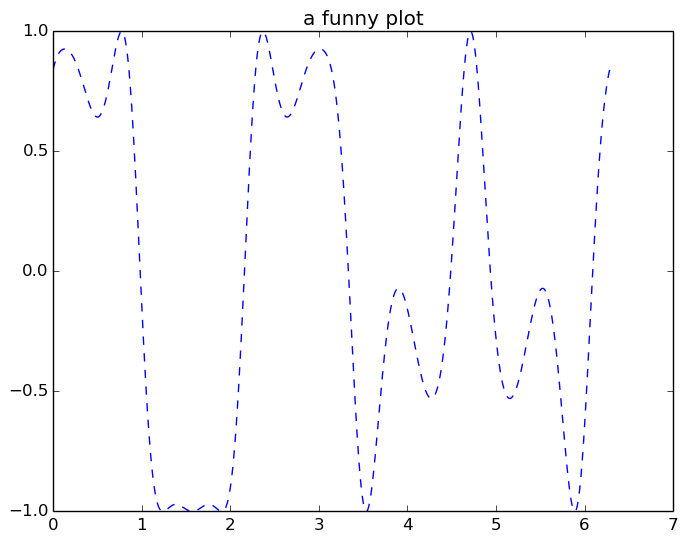

PyObject <matplotlib.text.Text object at 0x7fac84ef6c50>

In [33]:
x = linspace(0,2π,1000)
plot(x, sin(3x + cos(5x)), "b--")
title("a funny plot")

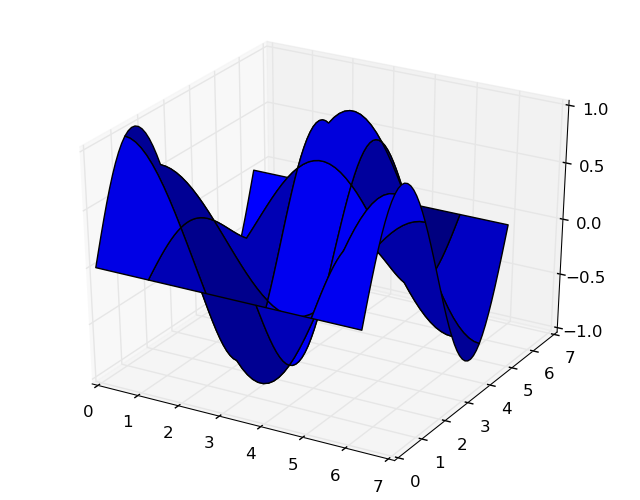

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fac84d44350>

In [34]:
y = linspace(0,2π,50)
surf(y, y, sin(y) .* cos(y)')

Really, the **whole Matplotlib API** is available for use.  It has everything you might want (in 2d, at least), if you dig long enough through the manuals:

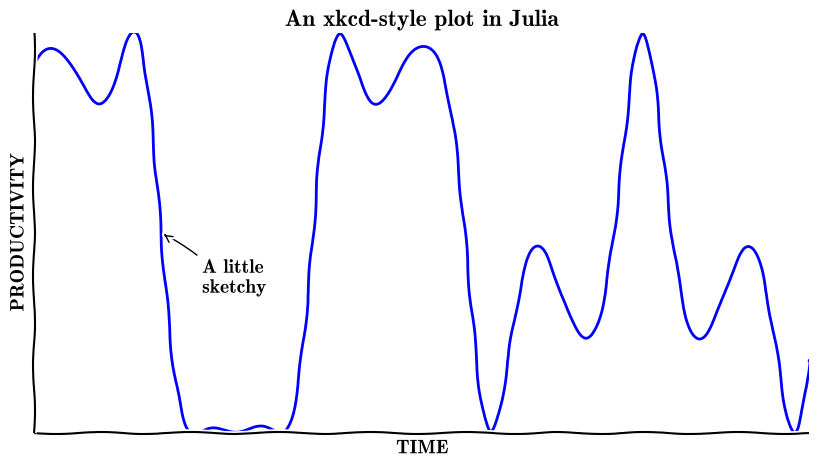


Use "Dict(a=>b, ...)" instead.
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['Humor Sans', 'Comic Sans MS', 'StayPuft'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=medium. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=large. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


In [35]:
clf()
xkcd()
fig = figure(figsize=(10,5))
ax = axes()
p = plot(x,sin(3x + cos(5x)))
ax[:set_xlim]([0.0,6])
annotate("A little\nsketchy",xy=[0.98,.001],arrowprops=["arrowstyle"=>"->"],xytext=[1.3,-0.3])

xticks([])
yticks([])
xlabel("TIME")
ylabel("PRODUCTIVITY")
title("An xkcd-style plot in Julia")

ax[:spines]["top"][:set_color]("none") # Remove the top axis boundary
ax[:spines]["right"][:set_color]("none") # Remove the right axis boundary
